In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 
from glob import glob 
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드 

In [3]:
with open('/content/drive/MyDrive/별떠라가자_공유폴더/AI파트/데이터/학습용/df_dict.pkl','rb') as f:
  df_dict = pickle.load(f)
id_list = list(df_dict.keys())

# 전처리

## Scaling 
- 마지막 df는 Valid로 사용 
- Scaling은 나머지 df로 해서 진행 
- Scaling 은 minmax으로 진행 

In [4]:
def cal_minmax():
  id = id_list[0]
  df= df_dict[id]
  df = np.array(df.drop(columns=['DATE','ID']))

  for id in id_list[1:-2]:
    temp_df= df_dict[id]
    temp_df= np.array(temp_df.drop(columns=['DATE','ID']))
    df = np.vstack([df,temp_df])
    
  min = np.min(df,axis=0)
  max = np.max(df,axis=0)
  return min,max

def scailng(df):
  global min,max
  scailed_df = (df-min)/(max-min)
  return scailed_df

## Train - Valid 분할 

In [5]:
def reshape_df(df):
  df = df.drop(columns = ['DATE','ID'])
  df = np.array(df).reshape(-1,19,6)
  return df 
def train_valid_split():
  train = reshape_df(df_dict[id_list[0]])
  for id in id_list[1:-2]:
    temp_train = df_dict[id]
    temp_train = reshape_df(temp_train)
    train = np.vstack([train,temp_train])

  valid = np.vstack([reshape_df(df_dict[id_list[-2]]),reshape_df(df_dict[id_list[-1]])])
  return train,valid

In [6]:
train,valid = train_valid_split()

# 제너레이터 

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,df,
                 batch_size: int,
               shuffle : bool = False):
        self.shuffle = shuffle        
        self.df = df 
        self.batch_size = batch_size
        
        
  def __len__(self):
    return math.ceil(len(self.df) / self.batch_size)

  def on_epoch_end(self):
    self.indices = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.df = self.df[self.indices]
    
  def __getitem__(self, index):
    self.batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]
    self.batch_df = scailng(self.batch_df).astype(float)
    return_value = self.batch_df 
    return return_value, return_value

# 오토인코더 

## 사전설정 

In [8]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization,Input,Dropout,Dense,Conv2D,Concatenate,Flatten,Conv1D,Conv2D,MaxPooling1D
from tensorflow.keras.layers import Reshape,Embedding,concatenate,Conv1DTranspose
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D,MaxPooling2D

## 콜백 

In [9]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    

#call backs 선언
plot_losses = PlotLosses()

## 모델 

In [10]:
input_shape = (19,6)
batch_size = 32
kernel_size = 3 
latent_dim = 8 
layer_filters = [32,64]

In [11]:
def conv_layer(input,filter):
  global kernel_size
  x = Conv1D(filters = filter,
             kernel_size = kernel_size,
             activation = 'relu',
             strides = 2,
             padding='same')(input)
  return x 

def convTranspose_layer(input,filter):
  global kernel_size
  x = Conv1DTranspose(filters = filter,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = 2,
            padding='same')(input)
  return x 

In [12]:
def make_encoder(input):
  x = Bidirectional(LSTM(64,return_sequences = True))(input)

  for i in [64,32,16,8,4]:
    x = Bidirectional(LSTM(i,return_sequences = True))(x)
    x= BatchNormalization()(x)
    x = Dropout(0.2)(x)
  x = Flatten()(x)
  output = Dense(latent_dim, activation = 'sigmoid')(x)
  encoder = Model(input,output,name='encoder')
  return encoder
  
def make_decoder():
  input = Input(shape=(latent_dim,))
  x = Dense(152, activation = 'sigmoid')(input)
  x = Reshape((19,8))(x)

  for i in [4,8,16,32,64]:
      x = Bidirectional(LSTM(i,return_sequences = True))(x)
      x = BatchNormalization()(x)
      x = Dropout(0.2)(x)
  x = Bidirectional(LSTM(64,return_sequences = True))(x)
  x = Dense(6,activation='sigmoid')(x)

  decoder = Model(input,x,name='decoder')
  return decoder

## compile 

In [13]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [14]:
from keras import backend as K
#rmse 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

##Wandb 

In [15]:
!pip install wandb
import wandb 
from wandb.keras import WandbCallback
wandb.init(project="taking_star", entity="crimama-",name='Autoencoder_0422_morebi_rmse')
wandb.config = {
  "learning_rate": lr_schedule,
  "epochs": 200,
  "batch_size": 128
}

# ... Define a model

     |████████████████████████████████| 1.8 MB 15.0 MB/s 
     |████████████████████████████████| 144 kB 73.9 MB/s 
     |████████████████████████████████| 181 kB 55.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a4e549bc05a97d104ade83fcc93cff957a2f4a1906ba762a7fc483ccb41cea3b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training 

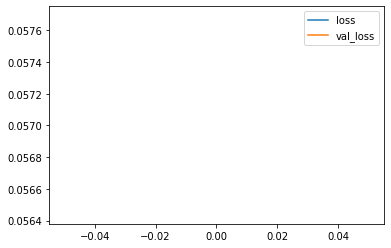

loss =  0.05644160881638527 , val_loss =  0.05768983066082001
2461/2461 [==============================] - 268s 91ms/step - loss: 0.0564 - mse: 0.0053 - val_loss: 0.0577 - val_mse: 0.0035 - _timestamp: 1650612519.0000 - _runtime: 295.0000
Epoch 2/20
1362/2461 [===============>..............] - ETA: 1:32 - loss: 0.0182 - mse: 5.2198e-04

In [ ]:
BATCH_SIZE = 128 
latent_dim = 8
min,max = cal_minmax()

#데이터 제너레이터 
train_generator = DataGenerator(train,128,True)
valid_generator = DataGenerator(valid,128,False)

#모델 선언 
input = Input((19,6))
encoder = make_encoder(input)
decoder = make_decoder()
autoencoder = Model(input,decoder(encoder(input)))

#컴파일 및 학습 
autoencoder.compile(optimizer=optimizer,loss = root_mean_squared_error,metrics = ['mse'])
history = autoencoder.fit(train_generator,
                          validation_data = valid_generator,
                          epochs=20,
                          verbose=1,
                          callbacks=[plot_losses,WandbCallback()])
#,WandbCallback()

#모델 저장 

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/별따러가자/model/0421_8벡터_minmax_19_6'
encoder.save(os.path.join(path,'encoder.h5'))
decoder.save(os.path.join(path,'decoder.h5'))
autoencoder.save(os.path.join(path,'autoencoder.h5'))

# 벡터 생산 

## 모델 로드 

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/별따러가자/model/0421_8벡터_minmax_19_6'
encoder = tf.keras.models.load_model(os.path.join(path,'encoder.h5'),compile=False)

## 테스트 데이터 로드 및 전처리 

In [ ]:
def make_generator(id):
  df = df_dict[id]
  test_df = reshape_df(df)
  test_generator = DataGenerator(test_df,128,False)
  return df,test_generator

def make_vectors(df,test_generator):
  y_ = encoder.predict(test_generator)
  vector = pd.DataFrame(np.unique(df['DATE'])).sort_values(by=0).reset_index(drop=True)
  vector = pd.concat([vector,pd.DataFrame(y_)],axis=1)
  return vector
  
min,max = cal_minmax()
vector_dict = {}
for id in tqdm(id_list):
  df, test_generator = make_generator(id)
  vector = make_vectors(df,test_generator)
  vector_dict[id] = vector 
meta = ["A50AF373,F257DB06 : Valid / 20211203,20211204,20211205 : Test / 나머지 : Train "]
vector_dict['meta'] = meta

In [ ]:
import pickle 
with open('/content/drive/MyDrive/별떠라가자_공유폴더/AI파트/데이터/벡터/vector_dict_0421.pkl','wb') as f:
  pickle.dump(vector_dict,f) 

In [ ]:
vector_dict.keys()